In [1]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
%matplotlib qt5

# Diseño para un motor de continua

Supongamos que la transferencia de nuestro sistema es:
$$G(s)=\frac{10}{s(s+2)(s+8)}$$
Diseño un controlador que ubique los polos en:
$$pc=[-1.42;\quad -1.04\pm2.14j]$$
y los del estimador tres veces más rápidos.

Como tenemos el sistema en forma de función transferencia lo llevamos a alguna forma en espacio de estados (la que sea por defecto de Python)


In [2]:
G=ctrl.tf(10,[1,10,16,0])
G


        10
-------------------
s^3 + 10 s^2 + 16 s

## Expresión en variables de estado

De las formas canónicas disponibles, elegimos la forma canónica de observabilidad.

In [3]:
ctrl.canonical_form?

Signature: ctrl.canonical_form(xsys, form='reachable')
Docstring:
Convert a system into canonical form

Parameters
----------
xsys : StateSpace object
    System to be transformed, with state 'x'
form : String
    Canonical form for transformation.  Chosen from:
      * 'reachable' - reachable canonical form
      * 'observable' - observable canonical form
      * 'modal' - modal canonical form

Returns
-------
zsys : StateSpace object
    System in desired canonical form, with state 'z'
T : matrix
    Coordinate transformation matrix, z = T * x
File:      c:\miniconda3\envs\dyc\lib\site-packages\control\canonical.py
Type:      function


In [4]:
sys,_=ctrl.canonical_form(ctrl.ss(G),'observable')
sys

A = [[-10.   1.   0.]
 [-16.   0.   1.]
 [ -0.   0.   0.]]

B = [[-3.46944695e-17]
 [-2.91433544e-16]
 [ 1.00000000e+01]]

C = [[1. 0. 0.]]

D = [[0.]]

## Ley de control y estimador completo



In [5]:
pc=np.array([-1.42, -1.04+2.14j,-1.04-2.14j])
pe = pc*3

Notar que hubiera podido escribir pc como una lista de los valores en donde quiero ubicar los polos a lazo cerrado. Sin embargo, luego no hubiera podido haer la operación de `pc*3` sobre la lista, ya que hubiera resultado en algo que no es lo que buscabamos.

**Obtenemos la ley de control:**

In [6]:
K=ctrl.place(sys.A,sys.B,pc)


**Obtenemos L del estimador:**

In [7]:
L=ctrl.place(sys.A.T,sys.C.T,pe).T

Hemos podido utilizar el comando `place` debido a que los 3 polos tanto del estimador como de los elegidos para la ley de control son distintos. De haber querido ubicar dos polos en el mismo lugar, hubieramos tenido que usar el comando `acker`.

Sin mebargo es necesario tener en cuenta que `acker` no es recomendable para sistema de orden mayor a 4.

### Sistema controlador con estimador completo

In [10]:
Dc=ctrl.ss(sys.A-sys.B@K-L@sys.C,L,-K,0)
ctrl.tf(Dc)
ctrl.isctime(Dc)

True

In [9]:
Dc.pole()

array([-2.93739746+8.32368499j, -2.93739746-8.32368499j,
        1.87479491+0.j        ])

Podemos ver que el controlador diseñado es inestable!. Esto no es deseable.

La razones por la que no es deseable un controlador inestable  son:

1. Presenta dificultades para ser testeado, ya sea el compensador por si solo o en lazo abierto durante la puesta en funcionamiento. Sin embargo, en agunos casos, se puede lograr una mejor performance del sistema de controlado con un controlador inestable (hay casos de sistemas que ni siquiera pueden ser estabilizados con controladores estables.). En ese caso se aceptan estos incevenientes de testeo.

2. Para ganancias bajas el sistema a lazo cerrado con un controlador inestable resulta inestable (visulizar el root locus). En general, los actuadores prensetan saturaciones, es decir valor máximos de actuación. Cuando un actuador satura se ve desde el punto de vista de lazo como una reducción de la ganancia, llevando a la zona instable o acercandose a la misma.

Los sistemas que necesitan se vuelven inestables cuando su valor ganancia se reduce se los conoce como sistemas **condicionalmente estables** y **deben ser evitados** en la medida de lo posible.


## Rediseñamos usando un estimador reducido

Ahora pondremos los polos tal que $\omega_n=6$ rad/seg y $\zeta=0.707$



In [10]:
pe_red= np.roots([1,2*0.707*6,6**2])
pe_red

array([-4.242+4.24328128j, -4.242-4.24328128j])

Necesitamos las sub-matrices de A para calcular el estimadore reducido

In [11]:
Aaa=sys.A[0:1,0:1]
Aab=sys.A[0:1,1:]
Aba=sys.A[1:,0:1]
Abb=sys.A[1:,1:]

Ba = sys.B[0:1,0]
Bb = sys.B[1:,0]

In [12]:
Aaa

array([[-10.]])

In [13]:
Ltred = ctrl.place(Abb.T,Aab.T,pe_red).T
Ltred

matrix([[ 8.484],
        [36.   ]])

### Sistema controlador con estimador reducido

In [14]:
Ka=K[0,0:1]
Kb=K[0,1:]

Ar = Abb-Ltred@Aab-(Bb-Ltred@Ba)@Kb
Br = Ar@Ltred + Aba - Ltred@Aaa - (Bb-Ltred@Ba)@Ka
Cr = -Kb
Dr = -Ka-Kb@Ltred


In [15]:
Dcr = ctrl.ss(Ar,Br,Cr,Dr)
Dcr

A = [[ -8.484    1.    ]
 [-93.6148   6.5   ]]

B = [[ 32.861744 ]
 [263.8811328]]

C = [[-5.76148  0.65   ]]

D = [[20.93051328]]

In [16]:
ctrl.tf(Dcr)


20.93 s^2 + 23.72 s - 28.94
---------------------------
   s^2 + 1.984 s + 38.47

In [17]:
Dcr.pole()

array([-0.992+6.12247793j, -0.992-6.12247793j])

In [18]:
Dcr.zero()

array([-1.871798  +0.j,  0.73868705+0.j])

Si bien este diseño mejoró al anterior ya que el controlador resultante es estable, este presenta un problema potencialmente menos danino. El problema es que es un controlador de no mínima fase, ya que tiene un 0 en el lado derecho del plano $s$, limitando la velocidad del sistema controlado.

In [34]:
L=-ctrl.tf(Dcr)*G/ctrl.db2mag(6)
ctrl.bode(L,dB=True, margins=True, omega_num=2000);

T=ctrl.feedback(L)
plt.figure()
ctrl.bode(T,dB=True);


In [36]:
ctrl.gangof4_plot(G,-ctrl.tf(Dcr))
ctrl.gangof4_plot(ctrl.tf(1,[1,0]),ctrl.tf(1,1))

In [40]:
plt.figure()
ctrl.nyquist(L);

(array([-3.52555461e-01, -3.52555970e-01, -3.52556711e-01, -3.52557790e-01,
        -3.52559362e-01, -3.52561650e-01, -3.52564983e-01, -3.52569836e-01,
        -3.52576901e-01, -3.52587188e-01, -3.52602161e-01, -3.52623952e-01,
        -3.52655655e-01, -3.52701755e-01, -3.52768745e-01, -3.52865995e-01,
        -3.53006970e-01, -3.53210905e-01, -3.53505032e-01, -3.53927422e-01,
        -3.54530312e-01, -3.55383475e-01, -3.56576545e-01, -3.58218375e-01,
        -3.60430968e-01, -3.63336636e-01, -3.67042303e-01, -3.71635443e-01,
        -3.77217189e-01, -3.83991407e-01, -3.92350112e-01, -4.02447611e-01,
        -4.09446509e-01, -3.57130984e-01,  2.19805619e-01,  4.88932815e-01,
         2.08760198e-01,  9.10688169e-02,  4.19151056e-02,  1.97741720e-02,
         9.41094151e-03,  4.48611934e-03,  2.13600869e-03,  1.01504887e-03,
         4.81435972e-04,  2.27979467e-04,  1.07824243e-04,  5.09495009e-05,
         2.40589660e-05,  1.13556160e-05]),
 array([-2.35647814e+01, -1.95266358e+01, -1

Agragamos referencia al controlador de orden reducido. 


In [22]:
def seguimiento_referencia(sys):
    aux1=np.vstack((np.hstack((sys.A,sys.B)),
                   np.hstack((sys.C,sys.D))))
    n=np.shape(sys.A)[0]
    aux2=np.vstack((np.zeros((n,1)),[1]))
    N=np.linalg.inv(aux1)@aux2
    Nx=N[0:n]
    Nu=N[n]
    return Nx, Nu
    

In [23]:
def calculate_Nbar(Nx,Nu,K):
    return Nu+K@Nx

In [25]:
Nx, Nu = seguimiento_referencia(sys)

In [27]:
Nbar = calculate_Nbar(Nx,Nu, K)
Nbar

matrix([[0.8038904]])

In [28]:
N=Nbar # Lo vemos mañana como se saca
M=(Bb-Ltred@Ba)*N
M

matrix([[0.      ],
        [8.038904]])

In [30]:

Dcr_ref = ctrl.ss(Ar, np.hstack((Br,M)), Cr, np.hstack((Dr,N)))
Dcr_ref

A = [[ -8.484    1.    ]
 [-93.6148   6.5   ]]

B = [[ 32.861744    0.       ]
 [263.8811328   8.038904 ]]

C = [[-5.76148  0.65   ]]

D = [[20.93051328  0.8038904 ]]

## Rediseño usando SRL

Vamos a diseñar el sistema para ubicar los polos de forma tal que se tenga un ancho de banda de 2.5rad/seg y que los polos del estimador esten aproximadamiente 2.5 veces más raṕido.

Para usar SRL vamos a tomat que $\mathbf{C} = \mathbf{C_1}$ y que $\mathbf{B} = \mathbf{B_1}$

In [ ]:
def conjugate_tf(G):
    num = ctrl.tf(G).num[0][0]
    den = ctrl.tf(G).den[0][0]
    nume = [num[i]*((-1)**(len(num)%2+1-i)) for i in range(0, len(num))]
    dene = [den[i]*((-1)**(len(den)%2+1-i)) for i in range(0, len(den))]
    return ctrl.tf(nume,dene)

In [ ]:
Gm=conjugate_tf(G)
Gm


         10
--------------------
-s^3 + 10 s^2 - 16 s

In [ ]:
_=ctrl.rlocus(G*Gm)

Con $K=26$ obtenemos los polos con una frecuenca de corte de 2.5 rad/seg.


In [ ]:
pc,_=ctrl.rlocus(G*conjugate_tf(G),kvect=[26],Plot=False)
pc = pc[pc.real<0]
pc

array([-8.04131959+0.j        , -2.00120126-1.52846879j,
       -2.00120126+1.52846879j])

Y con K=1350 tenemos los polos del estimador.

In [ ]:
pe,_=ctrl.rlocus(G*conjugate_tf(G),kvect=[1350],Plot=False)
pe = pe[pe.real<0]
pe

array([-9.16842047+0.j        , -4.00280684-4.90432763j,
       -4.00280684+4.90432763j])

In [ ]:
print("Polos de la ley de control: ",pc)
print("Polos del estimador: ",pe)

Polos de la ley de control:  [-8.04131959+0.j         -2.00120126-1.52846879j -2.00120126+1.52846879j]
Polos del estimador:  [-9.16842047+0.j         -4.00280684-4.90432763j -4.00280684+4.90432763j]


In [ ]:
K=ctrl.place(sys.A,sys.B,pc)
L=ctrl.place(sys.A.T,sys.C.T,pe).T

In [ ]:
Dcsrl=ctrl.ss(sys.A-sys.B@K-L@sys.C,L,-K,0)
ctrl.tf(Dcsrl)


    -93.59 s^2 - 982 s - 1873
---------------------------------
s^3 + 19.22 s^2 + 150.7 s + 632.6

In [ ]:
Dcsrl.pole()

array([-10.64805029+0.j        ,  -4.28485298+6.40706271j,
        -4.28485298-6.40706271j])

In [ ]:
Dcsrl.zero()

array([-2.50686229+0.j, -7.98559378+0.j])

In [ ]:
_=ctrl.bode((-sys*Dc,-sys*Dcr,-sys*Dcsrl),omega_limits=(1e-2,1e2),dB=True)

In [ ]:
print(ctrl.margin(-sys*Dc))
print(ctrl.margin(-sys*Dcr))
print(ctrl.margin(-sys*Dcsrl))

(0.6817283208672508, 13.183302483788026, 1.3027826533895248, 2.608292172554406)
(1.3198762960800223, -35.208651061695065, 2.07889863588063, 4.058211662618371)
(3.7818445925948114, 60.09561708471773, 5.497487495573457, 1.711784852716206)


In [ ]:
T1=ctrl.feedback(-sys*Dc)
T2=ctrl.feedback(-sys*Dcr)
T3=ctrl.feedback(-sys*Dcsrl)

In [ ]:
print(f"Los polos de T1 son: {T1.pole()}")
print(f"Los polos de T2 son: {T2.pole()}")
print(f"Los polos de T3 son: {T3.pole()}")

Los polos de T1 son: [-3.12+6.42j -3.12-6.42j -1.04+2.14j -1.04-2.14j -1.42+0.j   -4.26+0.j  ]
Los polos de T2 son: [-4.242+4.24328128j -4.242-4.24328128j -1.04 +2.14j
 -1.04 -2.14j       -1.42 +0.j        ]
Los polos de T3 son: [-9.16842047+0.j         -8.04131959+0.j         -4.00280684+4.90432763j
 -4.00280684-4.90432763j -2.00120126+1.52846879j -2.00120126-1.52846879j]


### Respuesta al escalón del sistema "controlado" (a partir de una salida distinta de 0)

In [ ]:
t1,y1 = ctrl.initial_response(T1, X0=np.matrix([0,0,0,-1,0,0]).T,T=np.linspace(0,5,1000))
t2,y2 = ctrl.initial_response(T2, X0=np.matrix([0,0,-1,0,0]).T,T=np.linspace(0,5,1000))
t3,y3 = ctrl.initial_response(T3, X0=np.matrix([0,0,0,-1,0,0]).T,T=np.linspace(0,5,1000))

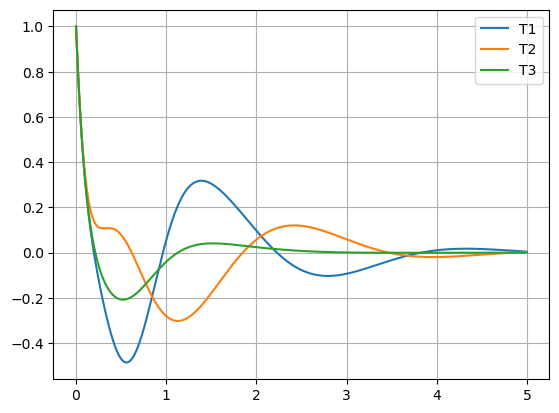

In [ ]:
plt.plot(t1,y1,label="T1")
plt.plot(t2,y2,label="T2")
plt.plot(t3,y3,label="T3")
plt.legend()
plt.grid()
plt.gcf()

## Conxión de sistemas entrada/salida

Podemos ver en el caso anterior que mediante el uso de la función ctrl.feedback hemos perdido, al menos parcialmente, saber de que manera estan ordenados los estados del sistema.

Par aun mayor control de como están ubicados los eatados, las entradas y la salidas es conveniente usar la función `ctrl.append` y `ctrl.connect`.

In [ ]:
ctrl.connect?

In [ ]:
sys_conectado_1 = ctrl.connect(ctrl.append(sys,Dc),
                               [[1,2],[2,1]],[],[1,2])
sys_conectado_1

A = [[-10.         1.         0.         0.         0.         0.      ]
 [-16.         0.         1.         0.         0.         0.      ]
 [  0.         0.         0.       464.109096 -57.6148     6.5     ]
 [  0.5        0.         0.       -10.5        1.         0.      ]
 [ 61.5332     0.         0.       -77.5332     0.         1.      ]
 [217.050408   0.         0.       247.058688 -57.6148     6.5     ]]

B = []

C = [[ 1.         0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.        46.4109096 -5.76148    0.65     ]]

D = []

In [ ]:
sys_conectado_2 = ctrl.connect(ctrl.append(sys,Dcr),[[1,2],[2,1]],[],[1,2])
sys_conectado_2

A = [[-10.          1.          0.          0.          0.       ]
 [-16.          0.          1.          0.          0.       ]
 [209.3051328   0.          0.        -57.6148      6.5      ]
 [ 32.861744    0.          0.         -8.484       1.       ]
 [263.8811328   0.          0.        -93.6148      6.5      ]]

B = []

C = [[ 1.          0.          0.          0.          0.        ]
 [20.93051328  0.          0.         -5.76148     0.65      ]]

D = []

In [ ]:
sys_conectado_3 = ctrl.connect(ctrl.append(sys, Dcsrl), [[1,2], [2,1]], [], [1,2])
sys_conectado_3

A = [[ -10.            1.            0.            0.            0.
     0.        ]
 [ -16.            0.            1.            0.            0.
     0.        ]
 [   0.            0.            0.            2.59335883   -2.08840003
    -2.04372211]
 [   7.17403415    0.            0.          -17.17403415    1.
     0.        ]
 [  97.47372448    0.            0.         -113.47372448    0.
     1.        ]
 [ 367.42346142    0.            0.         -364.83010259   -2.08840003
    -2.04372211]]

B = []

C = [[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.25933588 -0.20884    -0.20437221]]

D = []

La manera en que `ctrl.connect` trabaja es:

1. El primer argumento es un sistema de muchas entradas y muchas salidas que se tienen que interconectar. Para esto, agrupamos todos los sistemas que queremos interconectar mediante la función `ctrl.append`. Esta función nos va a devolver un único sistema en general de muchas entradas y muchas salidas.

2. El segundo argumento es una matriz de interconexión, donde cada fila nos dice que entrada se conecta con que salida. Las entradas y las salidas quedan ordenadas según el orden que hayamos puesto en la función `ctrl.append`, y están númeradas a partir de 1.

3. El tercer argumento, nos dice que entradas van a ser tomadas como entradas del sistema.

4. El cuarto y último argumento son las salidas del sistema.

Revisemos la utilización de `ctrl.connect` en nuetro ejemplo:

1. El primer argumento es un sistema construído a partir de `ctrl.append` que incluye a `sys` (la planta que queremos controlar) y a `Dc` (el controlador). Esta función nos va a devoler un sistema cuyos primeros 3 estados serán los estados de `sys` y los restantes son los del observador; tendrá dos donde la primer entrada es la de `sys` y la segunda entrada es la de `Dc`; y la primer salida es la de `sys` y la segunda salida es la de `Dc`.

2. El segundo argumento es la matriz de interconexión. Primero conecto la entrada de `sys` con la salida de `Dc`. Como `sys` en `ctrl.append` está primero, la entrada 1 corresponde a la de `sys` y la salida 2 corresponde a la salida de `Dc`. De esta manera tenemos la primer fila de `Q`. La segunda fila de `Q` conecta la entrada de `Dc` con la salida de `sys`.

3. El sistema que estamos generando no tiene entradas, pero el módulo de control tiene algunos problemas en sistemas que notienen entradas o que no tiene salidas, por eso el tercer argumento vamos a poner [1], que significa una entrada que se sumará a la salida de `Dc` en la entrada de `sys`.

4. El último argumento son las salidas. Voy a tomar como salidas de mi sistema el esfuerzo de control, es decir la salida del sistema `Dc`, y la salida de la planta, es decir la salida de `sys`.

Vamos a realizar nuevamente las simulaciones con los sistemas definidos mediante el connect.

In [ ]:
t1,y1 = ctrl.initial_response(sys_conectado_1, X0=np.matrix([1,0,0,0,0,0]).T,T=np.linspace(0,5,1000))
t2,y2 = ctrl.initial_response(sys_conectado_2, X0=np.matrix([1,0,0,0,0]).T,T=np.linspace(0,5,1000))
t3,y3 = ctrl.initial_response(sys_conectado_3, X0=np.matrix([1,0,0,0,0,0]).T,T=np.linspace(0,5,1000))
plt.figure()
plt.plot(t1,y1[0,:],label="T1")
plt.plot(t2,y2[0,:],label="T2")
plt.plot(t3,y3[0,:],label="T3")
plt.legend()
plt.grid()
plt.gcf()

ValueError: ignored

Podemos también mirar el esfuerzo de control, ya que es salida de la planta.

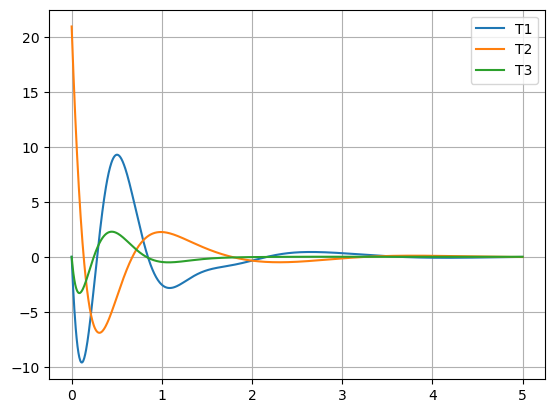

In [ ]:
t1,y1 = ctrl.initial_response(sys_conectado_1, X0=np.matrix([1,0,0,0,0,0]).T,T=np.linspace(0,5,1000))
t2,y2 = ctrl.initial_response(sys_conectado_2, X0=np.matrix([1,0,0,0,0]).T,T=np.linspace(0,5,1000))
t3,y3 = ctrl.initial_response(sys_conectado_3, X0=np.matrix([1,0,0,0,0,0]).T,T=np.linspace(0,5,1000))
plt.figure()
plt.plot(t1,y1[1,:],label="T1")
plt.plot(t2,y2[1,:],label="T2")
plt.plot(t3,y3[1,:],label="T3")
plt.legend()
plt.grid()
plt.gcf()

Este ejemplo muestra claramente como la elección de los polos usando cirterios de optimización como son los de lugar simétrico de las ráices nos da un control mucho mejor, tanto en tiempo de respuesta como en el esfuerzo de control.

In [31]:
psys_controlado_con_ref = ctrl.connect(ctrl.append(sys,Dcr_ref), [[1, 2],[2,1]], [3], [1,2])
psys_controlado_con_ref.pole()

array([-4.242+4.24328128j, -4.242-4.24328128j, -1.04 +2.14j      ,
       -1.04 -2.14j      , -1.42 +0.j        ])

In [34]:
ctrl.dcgain(psys_controlado_con_ref)

array([1.00000000e+00, 3.55271368e-15])

In [32]:
t,y = ctrl.step_response(psys_controlado_con_ref)

In [35]:
plt.plot(t,y[0,:])

In [36]:
plt.figure()
plt.plot(t,y[1,:])

## Control integral y estimador de orden completo

In [42]:
np.hstack((np.zeros((1,1)), sys.C))
np.hstack((np.zeros((3,1)), sys.A))


array([[  0., -10.,   1.,   0.],
       [  0., -16.,   0.,   1.],
       [  0.,  -0.,   0.,   0.]])

In [111]:
Au=np.vstack((np.hstack((np.zeros((1,1)), sys.C)),
              np.hstack((np.zeros((3,1)), sys.A))))
Au

array([[  0.,   1.,   0.,   0.],
       [  0., -10.,   1.,   0.],
       [  0., -16.,   0.,   1.],
       [  0.,  -0.,   0.,   0.]])

In [112]:
Bu = np.vstack((0,sys.B))
Bu

matrix([[ 0.],
        [ 0.],
        [ 0.],
        [10.]])

In [113]:

Ku = ctrl.place(Au,Bu, np.array([-1.42, -1.04+2.14j,-1.04-2.14j, -3])) 
Ku

matrix([[  2.4116712, -29.1264696,   3.81148  ,  -0.35     ]])

In [56]:
Ki=Ku[0,0]
Ki

2.411671199999967

In [82]:
integrador=ctrl.ss([[0]],[[Ki,-Ki]],[1],[0, 0])
integrador

A = [[0.]]

B = [[ 2.4116712 -2.4116712]]

C = [[1.]]

D = [[0. 0.]]

In [114]:
###  Estimado  mas ley de control

L=ctrl.place(sys.A.T, sys.C.T, np.array([-1.42, -1.04+2.14j,-1.04-2.14j])*3).T
L

matrix([[  0.5     ],
        [ 61.5332  ],
        [217.050408]])

In [115]:
Ae=sys.A-L@sys.C
Ae

matrix([[ -10.5     ,    1.      ,    0.      ],
        [ -77.5332  ,    0.      ,    1.      ],
        [-217.050408,    0.      ,    0.      ]])

In [116]:
Be=np.hstack((L,sys.B))
Be

matrix([[  0.5     ,   0.      ],
        [ 61.5332  ,   0.      ],
        [217.050408,  10.      ]])

In [117]:

Ce=-Ku[0,1:]
Ce

matrix([[29.1264696, -3.81148  ,  0.35     ]])

In [87]:
De=0
estim = ctrl.ss(Ae,Be,Ce,0)

In [88]:
estim

A = [[ -10.5         1.          0.      ]
 [ -77.5332      0.          1.      ]
 [-217.050408    0.          0.      ]]

B = [[  0.5        0.      ]
 [ 61.5332     0.      ]
 [217.050408  10.      ]]

C = [[29.1264696 -3.81148    0.35     ]]

D = [[0. 0.]]

In [122]:
planta_controlada = ctrl.connect(ctrl.append(sys, estim, integrador), 
                                 [[1,2],[1,3],[2,1],[3,2],[3,3],[5,1]],[4],[1,2,3])

In [123]:
planta_controlada

A = [[-10.          1.          0.          0.          0.          0.
    0.       ]
 [-16.          0.          1.          0.          0.          0.
    0.       ]
 [  0.          0.          0.        291.264696  -38.1148      3.5
   10.       ]
 [  0.5         0.          0.        -10.5         1.          0.
    0.       ]
 [ 61.5332      0.          0.        -77.5332      0.          1.
    0.       ]
 [217.050408    0.          0.         74.214288  -38.1148      3.5
   10.       ]
 [ -2.4116712   0.          0.          0.          0.          0.
    0.       ]]

B = [[0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [2.4116712]]

C = [[ 1.         0.         0.         0.         0.         0.
   0.       ]
 [ 0.         0.         0.        29.1264696 -3.81148    0.35
   0.       ]
 [ 0.         0.         0.         0.         0.         0.
   1.       ]]

D = [[0.]
 [0.]
 [0.]]

In [124]:
t,y = ctrl.step_response(planta_controlada)

In [125]:
plt.plot(t,y[1,:])

In [126]:
planta_controlada.pole()

array([-3.12+6.42j, -3.12-6.42j, -1.04+2.14j, -1.04-2.14j, -4.26+0.j  ,
       -3.  +0.j  , -1.42+0.j  ])

In [129]:
plt.plot(t,y[1,:])

In [128]:
plt.plot(t,y[0,:])